# QC filtering

This notebook is about filtering scATAC seq data within an adata object to archive a good quality peak matrix.
For this task various QC filters are implemented. The latter includes filters related to:

- doublet score
- number of features per barcode
- mean insert size
- promotor enrichment


## Settings

In [25]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/processed_data'
test = 'Stomach_95'

## QC Settings

In [26]:
# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "sample"

filter_xy = True  # True or False; filtering out chrX and chrY
binarize_mtx = True  # True or False; convert matrix to binary
select_hvf = True  # True or False; select only highly variable features

# Highly Variable Features thresholds:
min_limit = 1000
max_limit = 5000

############################# filters ##########################################

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = True

# Filter to use:
n_features_filter = True # True or False; filtering out cells with numbers of features not in the range defined below
mean_insertsize_filter = True # True or False; filtering out cells with mean insertsize not in the range defined below
filter_pct_fp= False # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_n_fragments= False # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_chrM_fragments= False # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_uniquely_mapped_fragments= False # True or False; filtering out cells with promotor_enrichment not in the range defined


# if this is True thresholds below are ignored 
only_automatic_thresholds = False # True or False; to use automatic thresholds

############################# set default values #######################################
# 
# This will be applied to all samples the thresholds can be changed manually when plotted 
# if thresholds None they are set automatically

# default values n_features 
min_features = 100
max_features = 5000

# default mean_insertsize
upper_threshold_mis=None
lower_threshold_mis=None

# default promotor enrichment
upper_threshold_pct_fp=None
lower_threshold_pct_fp=None

# default number of fragments
upper_thr_fragments=None
lower_thr_fragments=None

# default number of fragments in chrM
upper_thr_chrM_fragments=1000
lower_thr_chrM_fragments=0

# default number of uniquely mapped fragments
upper_thr_um=20000
lower_thr_um=0



## Sum up settings

In [27]:
manual_thresholds = {}
if n_features_filter:
    manual_thresholds['n_features_by_counts'] = {'min' : min_features, 'max' : max_features}

if mean_insertsize_filter:
    manual_thresholds['mean_insertsize'] = {'min' : lower_threshold_mis, 'max' : upper_threshold_mis}

if filter_pct_fp:
    manual_thresholds['pct_fragments_in_promoters'] = {'min' : lower_threshold_pct_fp, 'max' : upper_threshold_pct_fp}

if filter_n_fragments:
    manual_thresholds['TN'] = {'min' : lower_thr_fragments, 'max' : upper_thr_fragments}

if filter_chrM_fragments:
    manual_thresholds['CM'] = {'min' : lower_thr_chrM_fragments, 'max' : upper_thr_chrM_fragments}

if filter_uniquely_mapped_fragments:
    manual_thresholds['UM'] = {'min' : lower_thr_um, 'max' : upper_thr_um}

obs_columns = list(manual_thresholds.keys())

## Loading packages and setup

In [28]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *
from sctoolbox.atac_utils import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
import numpy as np

## Setup path handling object 

In [29]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [30]:
# probably updated in future
assembling_output = tree.assembled_anndata
adata = epi.read_h5ad(assembling_output)
adata

AnnData object with n_obs × n_vars = 73462 × 119892
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

In [31]:
adata.var 

,peak_chr,peak_start,peak_end,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
name,,,,,,,,,
b'chr1':10001-10595,chr1,10001,10595,530,0.008249,0.008215,99.278539,606.0,6.408529
b'chr1':11187-11337,chr1,11187,11337,0,0.000000,0.000000,100.000000,0.0,0.000000
b'chr1':28921-29450,chr1,28921,29450,12,0.000163,0.000163,99.983665,12.0,2.564949
b'chr1':34527-34969,chr1,34527,34969,0,0.000000,0.000000,100.000000,0.0,0.000000
b'chr1':91394-91476,chr1,91394,91476,0,0.000000,0.000000,100.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
b'chrY':57153540-57153622,chrY,57153540,57153622,0,0.000000,0.000000,100.000000,0.0,0.000000
b'chrY':57184033-57184210,chrY,57184033,57184210,0,0.000000,0.000000,100.000000,0.0,0.000000
b'chrY':57199873-57200000,chrY,57199873,57200000,0,0.000000,0.000000,100.000000,0.0,0.000000


<AxesSubplot:xlabel='Insertsize (bp)', ylabel='Count'>

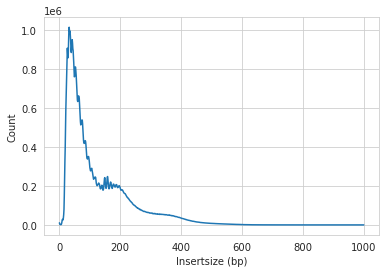

In [32]:
atac.plot_insertsize(adata)

# QC

## 1. filtering out chrX, chrY and chrM

In [33]:
non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
adata = adata[:, non_m]

In [34]:
if filter_xy:
    non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
    adata = adata[:, non_xy]

In [35]:
display(adata)

View of AnnData object with n_obs × n_vars = 73462 × 119892
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

## 2. removing empty cells and features

In [36]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=10)
#epi.pp.filter_features(adata, max_cells=2000)
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 67182 × 105026
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'

## 3. binarize

In [37]:
adata.raw = adata
if binarize_mtx:
    epi.pp.binarize(adata)
    adata.layers['binary'] = adata.X.copy()

## 5. visualize adata

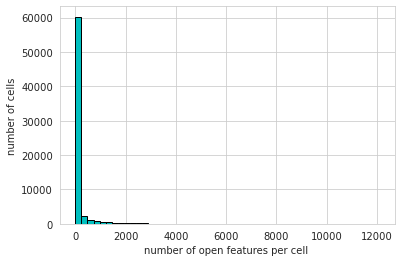

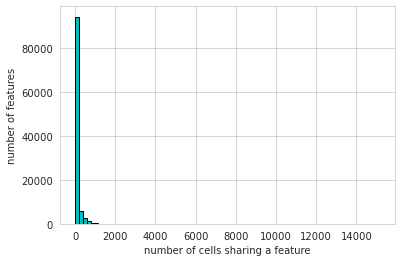

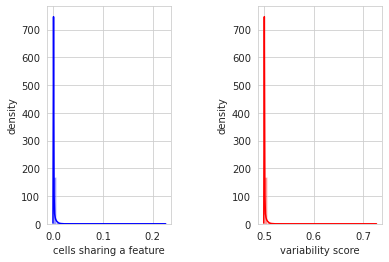

AnnData object with n_obs × n_vars = 67182 × 105026
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'
    layers: 'binary'

In [38]:
plot_ov_hist(adata, threshold_features=50) # FIXME: Later plots do not visualize

## 6. filter cells

### 6.1 get thresholds dict

In [39]:
groupby = condition_column if global_threshold is False else None
default_thresholds = build_default_thresholds(adata, manual_thresholds, groupby)
default_thresholds

{'n_features_by_counts': {'min': 100, 'max': 5000},
 'mean_insertsize': {'min': None, 'max': None}}

In [40]:
thresholds = get_thresholds_atac_wrapper(adata, default_thresholds, only_automatic_thresholds, groupby=None)
thresholds_as_table(thresholds)

,Parameter,Minimum,Maximum
0,n_features_by_counts,100.000000,5000.000000
1,mean_insertsize,-38.824601,250.602283


### 6.2 plot thresholds

In [41]:
%matplotlib widget
%bgcolor PowderBlue

#Plot violins and sliders
obs_figure, obs_slider_dict = quality_violin(adata, columns=obs_columns,
                                            groupby=condition_column,
                                            which="obs",
                                            thresholds=thresholds,
                                            global_threshold=global_threshold,
                                            title="Cell quality control (before)",
                                            save=tree.qc_plots + "cell_filtering.png")
obs_figure

In [42]:
# Get final thresholds
final_thresholds = get_slider_thresholds(obs_slider_dict)
thresholds_as_table(final_thresholds) # show thresholds

,Parameter,Minimum,Maximum
0,n_features_by_counts,100.0,5000.000000
1,mean_insertsize,0.0,250.602283


### 6.3 filter adata

In [43]:
apply_qc_thresholds(adata, final_thresholds)

Filtering based on 'n_features_by_counts' from 67182 -> 9263 cells
Filtering based on 'mean_insertsize' from 9263 -> 9258 cells


### remove empty features

In [44]:
epi.pp.filter_features(adata, min_cells=15)
# log-convert number of features
#adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 9258 × 82859
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'
    layers: 'binary'

## 7. save plots

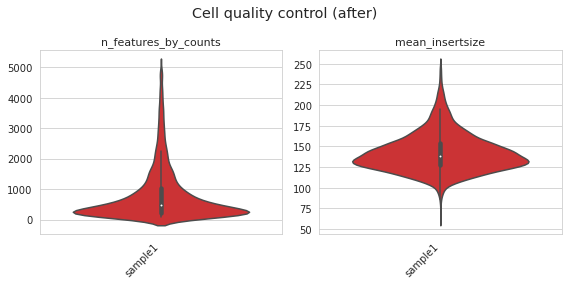

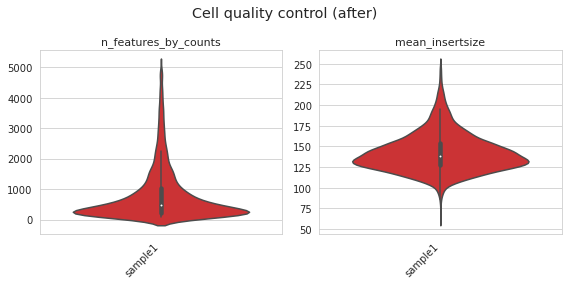

In [45]:
%matplotlib inline 

#Plot violins and sliders
figure, slider_dict = quality_violin(adata, columns=obs_columns,
                                     groupby=condition_column,
                                     which="obs", ncols=3,
                                     global_threshold = global_threshold,
                                     title="Cell quality control (after)",
                                     save=tree.qc_plots + "cell_filtering_final.png")
figure 

## 8. save anndata

In [46]:
adata.obs

,TN,UM,PP,UQ,CM,file,sample,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts,insertsize_count,mean_insertsize,nb_features,log_nb_features
barcode,,,,,,,,,,,,,,,
AACGAGAGCTAAACCTAAGTGG,3007.0,2632.0,2623.0,815.0,2.0,/mnt/workspace/jdetlef/data/anndata/stomach_95...,sample1,417,6.035481,461.0,6.135565,2616.0,138.47,414.0,2.620136
AACGAGAGCTAACCACCTAAAG,1196.0,1064.0,1055.0,312.0,0.0,/mnt/workspace/jdetlef/data/anndata/stomach_95...,sample1,139,4.941642,155.0,5.049856,1054.0,129.08,139.0,2.143015
AACGAGAGCTAACCGAATTCTC,4279.0,3837.0,3821.0,1124.0,2.0,/mnt/workspace/jdetlef/data/anndata/stomach_95...,sample1,697,6.548219,760.0,6.634634,3784.0,128.17,695.0,2.843233
AACGAGAGCTAAGCTAACGCAC,3627.0,3203.0,3192.0,972.0,32.0,/mnt/workspace/jdetlef/data/anndata/stomach_95...,sample1,501,6.218600,603.0,6.403574,3076.0,125.38,501.0,2.699838
AACGAGAGCTAATATAGGTCCG,71085.0,61317.0,61140.0,17636.0,698.0,/mnt/workspace/jdetlef/data/anndata/stomach_95...,sample1,3419,8.137396,4885.0,8.494129,60372.0,150.06,3383.0,3.533899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGCGCTTTTGACAAGTCCT,7334.0,6015.0,5985.0,1888.0,337.0,/mnt/workspace/jdetlef/data/anndata/stomach_95...,sample1,772,6.650279,1053.0,6.960348,5473.0,132.95,771.0,2.887617
TTTGGCGCTTTTGTTCCTCTGC,34360.0,29735.0,29642.0,9146.0,547.0,/mnt/workspace/jdetlef/data/anndata/stomach_95...,sample1,3478,8.154500,4834.0,8.483637,29279.0,147.14,3467.0,3.541330
TTTGGCGCTTTTTAACGCCTCT,87197.0,72794.0,72541.0,22199.0,652.0,/mnt/workspace/jdetlef/data/anndata/stomach_95...,sample1,2816,7.943428,3699.0,8.216088,70545.0,135.05,2784.0,3.449633


In [47]:
adata.var

,peak_chr,peak_start,peak_end,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,prop_shared_cells,variability_score
name,,,,,,,,,,,,,
b'chr1':10001-10595,chr1,10001,10595,530,0.008249,0.008215,99.278539,606.0,6.408529,459,530.0,0.007889,0.507889
b'chr1':180710-181006,chr1,180710,181006,113,0.001674,0.001673,99.846179,123.0,4.820282,96,113.0,0.001682,0.501682
b'chr1':181437-181983,chr1,181437,181983,52,0.000858,0.000857,99.929215,63.0,4.158883,41,52.0,0.000774,0.500774
b'chr1':629113-630044,chr1,629113,630044,2319,0.049931,0.048724,96.843266,3668.0,8.207674,1961,2319.0,0.034518,0.534518
b'chr1':630234-630475,chr1,630234,630475,333,0.004873,0.004861,99.546704,358.0,5.883322,293,333.0,0.004957,0.504957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'chrY':56850314-56850503,chrY,56850314,56850503,127,0.002273,0.002271,99.827122,167.0,5.123964,103,127.0,0.001890,0.501890
b'chrY':56850718-56850995,chrY,56850718,56850995,189,0.003730,0.003723,99.742724,274.0,5.616771,170,189.0,0.002813,0.502813
b'chrY':56851081-56851218,chrY,56851081,56851218,74,0.001184,0.001184,99.899268,87.0,4.477337,71,74.0,0.001101,0.501101


In [48]:
adata_output = tree.qc_anndata
adata.write(filename=adata_output)